# SVM Signature Recognition

## First we extract and split the data elements from the training image.

General Functions

In [1]:
##Note the new images are 28x28
## For image recognition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

##For image analysis
from skimage.io import imread
from skimage.transform import resize

##Library for extracting all images in a directory
import glob
import sys


## CONSTANTS
folder_strings = 'abcdefghijklmnopqrstuvwxyz'
smallestNumberOfElementsInEachCollection=sys.maxsize;

def printArrayImage(dataImage,letterArray,index):
    if(len(dataImage.shape)<=2):
        overall=[]
        temp = []
        counter = 0
        for x in range(len(dataImage[index])):
            temp.append(dataImage[index][x])
            counter=counter+1
            if(counter==28):
                overall.append(temp)
                counter=0
                temp=[]
            
        overall=np.asarray(overall)
        plt.imshow(overall, cmap='Greys', vmin=0, vmax=255)
        plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
        plt.show()
        print(f"Letter: {letterArray[index]}")
        return
    
    plt.imshow(dataImage[index], cmap='as_gray', vmin=0, vmax=255)
    plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
    plt.show()
    
def printImage(dataImage):
# #     if(len(dataImage.shape)<=2):
# #         overall=[]
# #         temp = []
# #         counter = 0
# #         for x in range(len(dataImage[index])):
# #             temp.append(dataImage[index][x])
# #             counter=counter+1
# #             if(counter==28):
# #                 overall.append(temp)
# #                 counter=0
# #                 temp=[]
            
#         overall=np.asarray(overall)
#         plt.imshow(overall, cmap='Greys', vmin=0, vmax=255)
#         plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
#         plt.show()
#         print(f"Letter: {letterArray[index]}")
#         return
    
    plt.imshow(dataImage, cmap='as_gray', vmin=0, vmax=255)
    plt.show()

def printAllImagesInDataSetWithPrediction(dataImage,letterArray,model,printImageToScreen=True,skip=0):
    local=smallestNumberOfElementsInEachCollection
    if(skip>0):
        local=skip
    print(len(dataImage))
    for x in range(0,len(dataImage),local):
        if(printImageToScreen):
            printImage(lettersArray,lettersTarget,x)
        print(f"The Model predicted {model.predict(lettersArray[x].reshape(1,-1))}, actual {lettersTarget[x]}")


#  Image extraction

In [2]:
## For image recognition
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

##For image analysis
from skimage.io import imread as mainImageRead
from skimage.transform import resize
from scipy.misc import imread, imresize, imsave
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.transform import resize
import skimage.segmentation as segment
from skimage.measure import regionprops
from scipy.ndimage.filters import gaussian_filter
import skimage as skimage
from sklearn.model_selection import train_test_split


##Library for extracting all images in a directory
import glob
import re
import os


class Extract_Letters:
    def extractFile(self, filename):
        image = imread(filename, 1)

        # apply threshold in order to make the image binary
        bw = (image > 120).astype(np.float)

        # remove artifacts connected to image border
        cleared = bw.copy()
        cleared = gaussian_filter(cleared, (2,1))
        cleared = cleared < 1
        segment.clear_border(cleared)


        # label image regions
        label_image = label(cleared, neighbors=4)
        borders = np.logical_xor(bw, cleared)
        label_image[borders] = -1
        
        letters = list()
        order = list()

        for region in regionprops(label_image):
            minr, minc, maxr, maxc = region.bbox
            # skip small images
#             if region.area > 40:
            if region.area > 80:##175 MAKES IT IDEAL FOR DATA EXTRACTION!
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                order.append(region.bbox)

        # sort the detected characters left->right, top->bottom
        lines = list()
        first_in_line = ''
        counter = 0

        # worst case scenario there can be 1 character per line
        for x in range(len(order)):
            lines.append([])

        for character in order:
            if first_in_line == '':
                first_in_line = character
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
                first_in_line = character
                counter += 1
                lines[counter].append(character)

        for x in range(len(lines)):
            lines[x].sort(key=lambda tup: tup[1])

        final = list()
        prev_tr = 0
        prev_line_br = 0

        for i in range(len(lines)):
            for j in range(len(lines[i])):
                tl_2 = lines[i][j][1]
                bl_2 = lines[i][j][0]
                if tl_2 > prev_tr and bl_2 > prev_line_br:
                    tl, tr, bl, br = lines[i][j]
                    letter_raw = bw[tl:bl, tr:br]
                    letter_norm = resize(letter_raw, (200, 200))
                    final.append(letter_norm)
                    prev_tr = lines[i][j][3]
                if j == (len(lines[i]) - 1):
                    prev_line_br = lines[i][j][2]
            prev_tr = 0
            tl_2 = 0
            ##print ('Characters recognized: ' + str(len(final)))
        print(f"Totally recognised {len(final)} characters")
        return final
    
    def __init__(self):
        print("Extracting characters...")


        
        
trainingSave = "ocr/beingTrained/"
trainingDirectory = "ocr/training/"

trainingFileNames = {}
trainingTarget =[]
trainingPicture =[]

nonCorrectedNames = glob.glob(f"{trainingDirectory}*")
counter = 0
extract = Extract_Letters()
for x in range(len(nonCorrectedNames)):
    currentUserName = nonCorrectedNames[x][len(trainingDirectory):]
    imagesDirectory = glob.glob(f"{nonCorrectedNames[x]}/*.png")
    for imageLocation in imagesDirectory:
        if not os.path.exists(trainingSave+currentUserName):
            os.makedirs(trainingSave+currentUserName)
        extractedSignature=extract.extractFile(imageLocation)
        for signature in extractedSignature:
            imsave(f"{trainingSave}{currentUserName}/{counter}.png", signature)
            ##Extract the image
            img = mainImageRead(f"{trainingSave}{currentUserName}/{counter}.png",as_grey=True)
            arr = np.asarray(img)
            arr=arr.flatten()
            ##Add extracted image
            trainingPicture.append(np.asarray(arr))
            trainingTarget.append(x)
            trainingFileNames[x] = currentUserName
            
            counter=counter+1
        

trainingTarget = np.asarray(trainingTarget)
trainingPicture = np.asarray(trainingPicture)

print(trainingFileNames)
print(trainingTarget.shape)
print(trainingPicture.shape)


target_train, target_test, image_train, image_test = train_test_split(trainingTarget, trainingPicture, test_size=0.33, random_state=42)


Extracting characters...


/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Totally recognised 127 characters


/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/jeeson/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Totally recognised 20 characters
Totally recognised 65 characters
Totally recognised 45 characters
Totally recognised 154 characters
Totally recognised 124 characters
{0: 'user3', 1: 'user1', 2: 'user4', 3: 'user2'}
(535,)
(535, 40000)


In [3]:
print(len(image_test))

177


## Generating the model

In [4]:
# Import model KNN training model
from sklearn.neighbors import KNeighborsClassifier
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Analysis metrics
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn import svm

#Create KNN Classifier
model =  svm.SVC(kernel='rbf')


##Below is not really needed, but present instead corss-validation on test data is needed
sigImageShuffled,targetShuffled = shuffle(image_train,target_train) ## Ensures non bias suffling

model.fit(sigImageShuffled, targetShuffled)

y_pred = model.predict(image_test)

print("Accuracy, with 100% of test and target being training( I.e just checking if method is workig):",metrics.accuracy_score(target_test, y_pred))


Accuracy, with 100% of test and target being training( I.e just checking if method is workig): 0.9887005649717514


In [5]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#Remember that printmd is just but cooler looking :)
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score , f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_predict

def printConfusionMatrixToScreen(confusionMatrix):
    print("As pure print")
    for x in range(len(confusionMatrix)):
        print("[",end="")
        for y in range(len(confusionMatrix[x])):
            print(f"|{confusionMatrix[x][y]}|",end="")
        print("]")
      
      
def plotConfusionMatrix(prediction,target,fileName):
    confusionMatrix=confusion_matrix(target,prediction)
    print(confusionMatrix)
    df_cm = pd.DataFrame(confusionMatrix, index = [i for i in range(len(confusionMatrix[0]))],
                  columns = [i for i in range(len(confusionMatrix[0]))])
    plt.figure(figsize = (24,14))
    plt.suptitle(f"{fileName[0].upper()+fileName[1:]} Confusion Matrix", fontsize=50)
    sn.heatmap(df_cm, annot=True)
    plt.show()
    ##printConfusionMatrixToScreen(confusionMatrix)

    
def calculateAccuracyMetrics(prediction,target):
    printmd(f"**Accuracy:** {metrics.accuracy_score(target,prediction)}\n")
    printmd(f"**Precision:** {precision_score(target, prediction,average='weighted',zero_division=1)}")
    printmd(f"**Recall:** {recall_score(target, prediction,average='weighted')}")
    printmd(f"**F1 score:** {f1_score(target, prediction,average='weighted')}")
            
def plotRocAucCurve(model,nonPredicted,prediction,target):
    import sklearn.metrics as metrics
    print(nonPredicted[::,1].shape)
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(nonPredicted)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
      

**Accuracy:** 0.9887005649717514


**Precision:** 0.9889656362790153

**Recall:** 0.9887005649717514

**F1 score:** 0.9887061509330887

[[47  0  1  0]
 [ 0 38  0  0]
 [ 0  0 46  0]
 [ 0  1  0 44]]


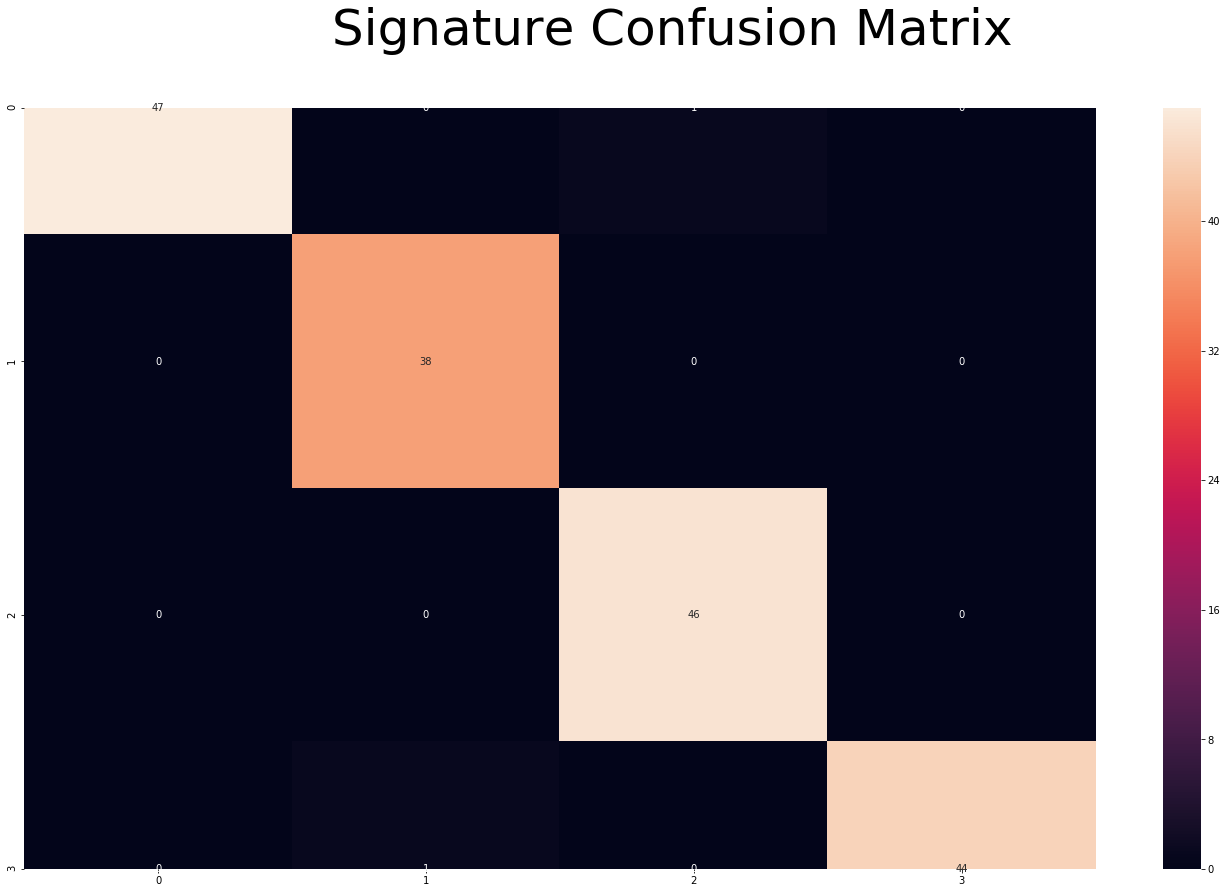

In [6]:
def runModelAcrossAllFiles(model,lettersTestArray,lettersTestTarget):
    modelPrediction = model.predict(lettersTestArray)
    calculateAccuracyMetrics(modelPrediction,lettersTestTarget)
    plotConfusionMatrix(modelPrediction,lettersTestTarget,"Signature")
    


runModelAcrossAllFiles(model,image_test,target_test)
# printAllImagesInDataSetWithPrediction(lettersTestArray[1],lettersTestTarget,model,True,skip=100)